In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_csv("updated_medical_train.csv")

train = train_df.drop(columns='Medical Cost').to_numpy(dtype='float64', copy=True)
train_y = train_df['Medical Cost'].to_numpy(dtype='float64', copy=True)

print(train.shape)
print(train_y.shape)

# Convert to 2D PyTorch tensors
X = torch.tensor(train, dtype=torch.float32)
y = torch.tensor(train_y, dtype=torch.float32).reshape(-1, 1)

print(X.shape)
print(y.shape)

(6000, 8)
(6000,)
torch.Size([6000, 8])
torch.Size([6000, 1])


In [ ]:
test_df = pd.read_csv("updated_medical_test.csv")

test = test_df.drop(columns='Medical Cost').to_numpy(dtype='float64', copy=True)
test_y = test_df['Medical Cost'].to_numpy(dtype='float64', copy=True)

print(test.shape)
print(test_y.shape)

# Convert to 2D PyTorch tensors
X_test = torch.tensor(test, dtype=torch.float32)
y_test = torch.tensor(test_y, dtype=torch.float32).reshape(-1, 1)

print(X_test.shape)
print(y_test.shape)

(2000, 8)
(2000,)
torch.Size([2000, 8])
torch.Size([2000, 1])


In [ ]:
train_df

,Age,BMI,Children,Medical Cost,Sex~male,Smoker~yes,Region~northwest,Region~southeast,Region~southwest
0,0.042553,0.772,0.0,0.768239,True,True,False,False,False
1,0.617021,0.164,0.4,0.865271,False,True,False,True,False
2,0.574468,0.360,0.2,0.138651,False,False,False,False,False
3,0.148936,0.628,1.0,0.116429,True,False,False,False,False
4,0.617021,0.952,1.0,0.204466,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
5995,0.148936,0.452,1.0,0.854807,True,True,False,False,False
5996,0.127660,0.476,0.4,0.776791,False,True,False,True,False
5997,0.723404,0.924,1.0,0.909439,False,True,True,False,False
5998,0.127660,0.736,0.8,0.111393,True,False,True,False,False


In [ ]:
# Define PyTorch model, with dropout at hidden layers
class MCDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 32)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(32, 32)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
def model_train(model, X_train, y_train, X_val, y_val,
                n_epochs=300, batch_size=16):
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    for epoch in range(n_epochs):
      if epoch % 50 == 0:
        print("Epoch:", epoch)
        for start in batch_start:
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [ ]:
model = MCDropout()

mse = model_train(model, X, y, X_test, y_test, n_epochs=1000)

loss_fn = nn.MSELoss()
y_pred = model(X_test)

mse = loss_fn(y_pred, y_test)
print("RMSE:", np.sqrt(mse.detach().numpy()))


Epoch: 0
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Epoch: 300
Epoch: 350
Epoch: 400
Epoch: 450
Epoch: 500
Epoch: 550
Epoch: 600
Epoch: 650
Epoch: 700
Epoch: 750
Epoch: 800
Epoch: 850
Epoch: 900
Epoch: 950
tensor([[0.8675],
        [0.7559],
        [0.9296],
        ...,
        [0.1646],
        [0.1966],
        [0.8814]], grad_fn=<AddmmBackward0>)
RMSE: 0.060056504


In [ ]:
T = 50

results = None

for i in range(T):
  y_pred = model(X_test)

  iter = y_pred.detach().numpy()

  if i == 0:
    results = iter
  else:
    results = np.append(results, iter, axis=1)

mu = np.mean(results, axis=1)
sigma = np.std(results, ddof=1, axis=1)

print(mu)
print(sigma)

predictions = test_df.copy()
predictions['Mean'] = mu
predictions['Uncertainty'] = sigma

predictions = predictions[['Medical Cost', 'Mean', 'Uncertainty']]
predictions

[0.7924907  0.76251924 0.8698861  ... 0.1501191  0.1773431  0.8744751 ]
[0.06146098 0.06312219 0.06811487 ... 0.04903081 0.04410432 0.06638369]


,Medical Cost,Mean,Uncertainty
0,0.824914,0.792491,0.061461
1,0.760608,0.762519,0.063122
2,0.869827,0.869886,0.068115
3,0.818766,0.803475,0.053078
4,0.911445,0.890108,0.066176
...,...,...,...
1995,0.163964,0.159276,0.061546
1996,0.105311,0.123782,0.036588
1997,0.159146,0.150119,0.049031
1998,0.169317,0.177343,0.044104


0.1822181818181818

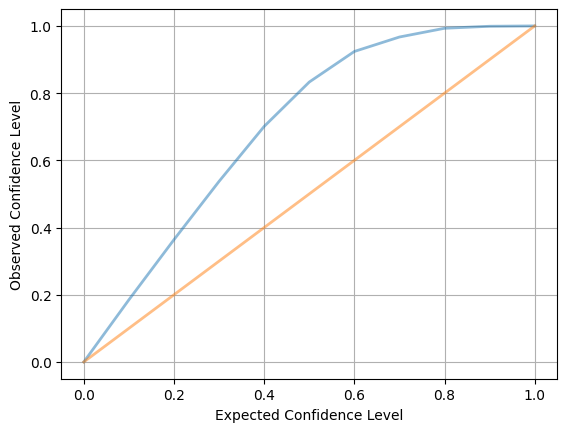

In [ ]:
def qce(test_predictions, n_quantiles, n_bins, filename):
  quantiles = np.linspace(0, 1, n_quantiles+1)

  df = test_predictions.sort_values('Uncertainty')

  # Variance ranges for binning
  cutoffs = np.linspace(df['Uncertainty'].iloc[0],
                        df['Uncertainty'].iloc[len(df)-1],
                        n_bins+1)

  error = 0.0
  observed = []

  # For each confidence level
  for p in quantiles:
    bin_freqs = [0 for _ in range(n_bins)]
    bin_counts = [0 for _ in range(n_bins)]
    i = 0
    # For each prediction
    for j in range(len(df)):
      point = df.iloc[j]
      mu = point['Mean']
      s = point['Uncertainty']
      y = point['Medical Cost']

      # Place point in appropriate bin
      if s > cutoffs[i+1]:
        i += 1
      bin_counts[i] += 1

      # Calculate confidence interval
      z = stats.norm.ppf((1 + p) / 2)
      if np.abs(mu - y) <= z * s:
        bin_freqs[i] += 1

    freq = [bin_freqs[i]/bin_counts[i] for i,_ in enumerate(bin_freqs)]
    qce = sum(bin_counts[i] * np.abs(freq[i] - p) for i,_ in enumerate(freq))
    empirical = sum(bin_counts[i] * freq[i] for i,_ in enumerate(freq))
    observed.append(empirical / len(df))
    error += (qce / len(df))

  error = error / (n_quantiles+1)

  if filename == None:
    return error

  fig, ax = plt.subplots()
  ax.plot(quantiles, observed, linewidth=2, alpha=.5)
  ax.plot(quantiles, quantiles, linewidth=2, alpha=.5)

  ax.set_xlabel(r'Expected Confidence Level')
  ax.set_ylabel(r'Observed Confidence Level')
  ax.grid()

  plt.savefig(filename)
  return error


qce(predictions, 10, 10, "dropout_calibration_plot")


0.27899999999999997

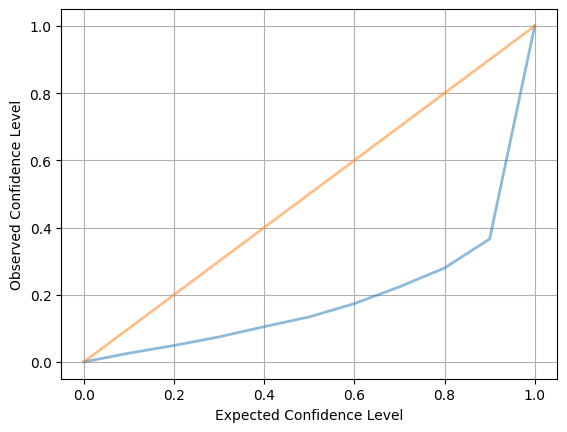

In [ ]:
predictions_gp = pd.read_csv('gaussian_processes_medical_test.csv')

predictions_gp = predictions_gp[['Medical Cost', 'Mean', 'Uncertainty']]
predictions_gp

qce(predictions_gp, 10, 10, "gp_calibration_plot")